In [31]:
import re
import itertools
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import datasets
from scipy.spatial import distance
import networkx as nx

In [32]:
base_color = 'darkturquoise'


* Use The 20 newsgroups text dataset. See http://scikit-learn.org/stable/datasets/twenty_newsgroups.html#newsgroups

In [3]:
categories = ['rec.sport.baseball', 'sci.space']
train = datasets.fetch_20newsgroups(subset='train', categories=categories)
valid = datasets.fetch_20newsgroups(subset='test', categories=categories)

train.data = np.array(train.data, dtype=np.object)
valid.data = np.array(valid.data, dtype=np.object)

In [4]:
len(train.data), len(train.target), len(valid.data), len(valid.target)

(1190, 1190, 791, 791)

In [5]:
indices = np.where(train.target == 0)
len(train.data[indices])

597

In [6]:
indices = np.where(train.target == 1)
len(train.data[indices])

593

In [7]:
def analyzer(text):
    
    stop_words = ['i', 'a', 'an', 'the', 'to', 'and', 'or', 'if', 'is', 'are', 'am', 'it', 'this', 'that', 'of', 'from', 'in', 'on']
    text = text.lower() # 小文字化
    text = text.replace('\n', '') # 改行削除
    text = text.replace('\t', '') # タブ削除
    text = re.sub(re.compile(r'[!-\/:-@[-`{-~]'), ' ', text) # 記号をスペースに置き換え
    text = text.split(' ') # スペースで区切る
    
    words = []
    for word in text:
        if (re.compile(r'^.*[0-9]+.*$').fullmatch(word) is not None): # 数字が含まれるものは除外
            continue
        if word in stop_words: # ストップワードに含まれるものは除外
            continue
        if len(word) < 2: #  1文字、0文字（空文字）は除外
            continue
        words.append(word)
        
    return words

In [49]:
indices = np.where(train.target == 0)
corpus = train.data[indices]

vectorizer = CountVectorizer(analyzer=analyzer, min_df=0.2, max_df=0.8)
vectorizer.fit_transform(corpus)

<597x70 sparse matrix of type '<class 'numpy.int64'>'
	with 13581 stored elements in Compressed Sparse Row format>

In [50]:
vectorizer.transform(corpus).toarray().shape, len(vectorizer.get_feature_names())

((597, 70), 70)

In [51]:
word_counts = vectorizer.transform(corpus).toarray()
word_counts = np.sum(word_counts, axis=0)
df_word_counts = pd.DataFrame({'word': vectorizer.get_feature_names(), 'cnt': word_counts})
len(df_word_counts)

70

In [52]:
df_word_counts[['cnt']].describe()

,cnt
count,70.000000
mean,351.642857
std,190.966196
min,129.000000
25%,227.250000
50%,288.000000
75%,374.750000
max,1085.000000


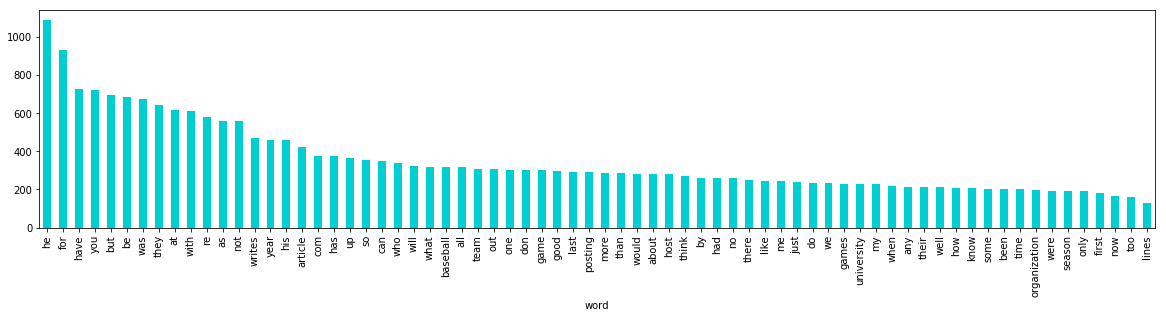

In [54]:
df_word_counts.sort_values(by='cnt', ascending=False) \
    .plot(kind='bar', x='word', y='cnt', figsize=(20,4), color=base_color, legend=False)
plt.show()

In [55]:
# 共起数を数える

vocab_num = len(vectorizer.get_feature_names())
combination_matrix = np.zeros((vocab_num, vocab_num))

for word_cnt_vec in vectorizer.transform(corpus).toarray():
    word_pair_indices = list(itertools.combinations(np.where(word_cnt_vec != 0)[0], 2)) # 共起ペアのリスト
    for i, j in word_pair_indices:
        combination_matrix[i, j] += 1
        combination_matrix[j, i] += 1
        
for i in range(vocab_num):
    combination_matrix[i, i] /= 2
    
combination_matrix

array([[   0.,   84.,   69., ...,  122.,   84.,  114.],
       [  84.,    0.,   72., ...,  128.,   84.,  125.],
       [  69.,   72.,    0., ...,  113.,   58.,   89.],
       ..., 
       [ 122.,  128.,  113., ...,    0.,  120.,  168.],
       [  84.,   84.,   58., ...,  120.,    0.,  107.],
       [ 114.,  125.,   89., ...,  168.,  107.,    0.]])

In [56]:
jaccard_matrix = 1-distance.cdist(combination_matrix, combination_matrix, 'jaccard')
jaccard_matrix

array([[ 1.        ,  0.04285714,  0.02857143, ...,  0.        ,
         0.05714286,  0.        ],
       [ 0.04285714,  1.        ,  0.        , ...,  0.        ,
         0.04285714,  0.        ],
       [ 0.02857143,  0.        ,  1.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.05714286,  0.04285714,  0.        , ...,  0.        ,
         1.        ,  0.01428571],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.01428571,  1.        ]])

Node count: 1009


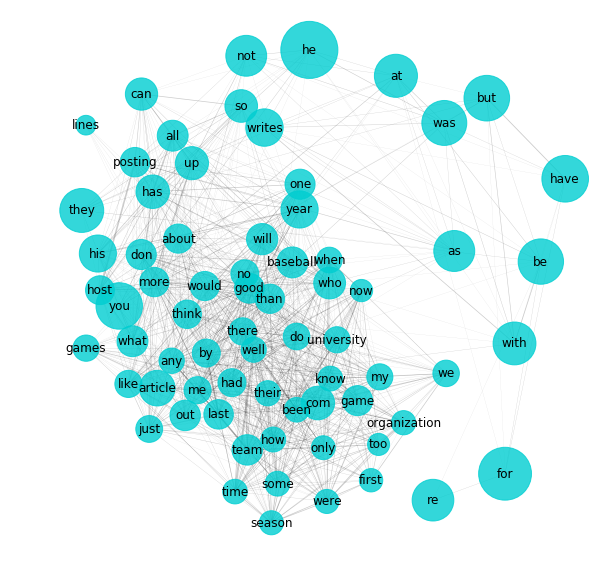

In [58]:
nodes = []
vocabs = vectorizer.get_feature_names()

for i in range(vocab_num):
    for j in range(i+1, vocab_num):
        jaccard = jaccard_matrix[i, j]
        if jaccard > 0:
            nodes.append([vocabs[i], vocabs[j], word_counts[i], word_counts[j], jaccard])

print('Node count: {}'.format(len(nodes)))

G = nx.Graph()
G.nodes(data=True)

for pair in nodes:
    
    node_x, node_y, node_x_cnt, node_y_cnt, jaccard = pair[0], pair[1], pair[2], pair[3], pair[4]
    
    if not G.has_node(node_x):
        G.add_node(node_x, count=node_x_cnt)
    if not G.has_node(node_y):
        G.add_node(node_y, count=node_y_cnt)
    if not G.has_edge(node_x, node_y):
        G.add_edge(node_x, node_y, weight=jaccard)
        
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=0.5)

node_size = [d['count']*3 for (n,d) in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_color=base_color, alpha=0.8, node_size=node_size)
nx.draw_networkx_labels(G, pos, fontsize=14)

edge_width = [d['weight']*10 for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='black', width=edge_width)

plt.axis('off')
plt.show()

Node count: 936


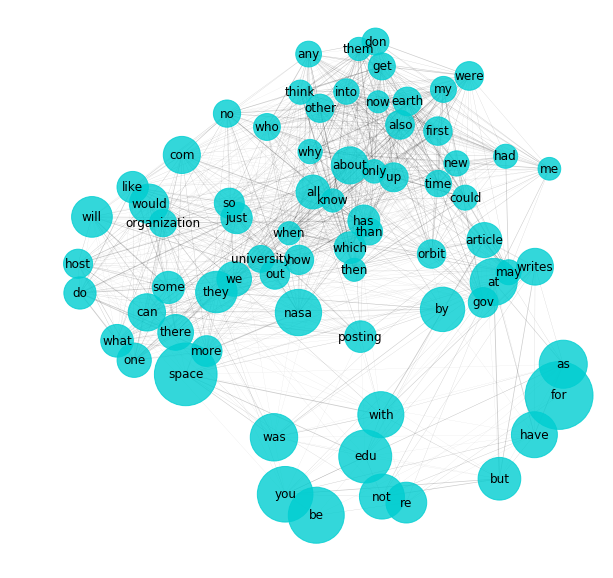

In [59]:
# category = sci.space

indices = np.where(train.target == 1)
corpus = train.data[indices]

vectorizer = CountVectorizer(analyzer=analyzer, min_df=0.2, max_df=0.8)
vectorizer.fit_transform(corpus)

word_counts = vectorizer.transform(corpus).toarray()
word_counts = np.sum(word_counts, axis=0)
df_word_counts = pd.DataFrame({'word': vectorizer.get_feature_names(), 'cnt': word_counts})

vocab_num = len(vectorizer.get_feature_names())
combination_matrix = np.zeros((vocab_num, vocab_num))

for word_cnt_vec in vectorizer.transform(corpus).toarray():
    word_pair_indices = list(itertools.combinations(np.where(word_cnt_vec != 0)[0], 2)) # 共起ペアのリスト
    for i, j in word_pair_indices:
        combination_matrix[i, j] += 1
        combination_matrix[j, i] += 1
        
for i in range(vocab_num):
    combination_matrix[i, i] /= 2
    
jaccard_matrix = 1-distance.cdist(combination_matrix, combination_matrix, 'jaccard')

nodes = []
vocabs = vectorizer.get_feature_names()

for i in range(vocab_num):
    for j in range(i+1, vocab_num):
        jaccard = jaccard_matrix[i, j]
        if jaccard > 0:
            nodes.append([vocabs[i], vocabs[j], word_counts[i], word_counts[j], jaccard])

print('Node count: {}'.format(len(nodes)))

G = nx.Graph()
G.nodes(data=True)

for pair in nodes:
    
    node_x, node_y, node_x_cnt, node_y_cnt, jaccard = pair[0], pair[1], pair[2], pair[3], pair[4]
    
    if not G.has_node(node_x):
        G.add_node(node_x, count=node_x_cnt)
    if not G.has_node(node_y):
        G.add_node(node_y, count=node_y_cnt)
    if not G.has_edge(node_x, node_y):
        G.add_edge(node_x, node_y, weight=jaccard)
        
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=0.5)

node_size = [d['count']*3 for (n,d) in G.nodes(data=True)]
nx.draw_networkx_nodes(G, pos, node_color=base_color, alpha=0.8, node_size=node_size)
nx.draw_networkx_labels(G, pos, fontsize=14)

edge_width = [d['weight']*10 for (u,v,d) in G.edges(data=True)]
nx.draw_networkx_edges(G, pos, alpha=0.2, edge_color='black', width=edge_width)

plt.axis('off')
plt.show()

In [60]:
!python --version

Python 3.6.6


In [61]:
!pip freeze

alembic==0.9.9
asn1crypto==0.24.0
attrs==18.1.0
Automat==0.0.0
backcall==0.1.0
beautifulsoup4==4.6.1
bleach==2.1.3
bokeh==0.12.16
boto==2.49.0
boto3==1.7.71
botocore==1.10.71
bz2file==0.98
certifi==2018.4.16
cffi==1.11.5
chardet==3.0.4
cloudpickle==0.5.3
conda==4.5.8
constantly==15.1.0
cryptography==2.2.1
cycler==0.10.0
Cython==0.28.5
dask==0.18.2
decorator==4.3.0
dill==0.2.8.2
docutils==0.14
entrypoints==0.2.3
fastcache==1.0.2
gensim==3.5.0
gmpy2==2.0.8
h5py==2.7.1
html5lib==1.0.1
hyperlink==17.3.1
idna==2.7
imageio==2.3.0
incremental==17.5.0
ipykernel==4.8.2
ipython==6.5.0
ipython-genutils==0.2.0
ipywidgets==7.2.1
jedi==0.12.1
Jinja2==2.10
jmespath==0.9.3
jsonschema==2.6.0
jupyter-client==5.2.3
jupyter-core==4.4.0
jupyterhub==0.8.1
jupyterlab==0.33.4
jupyterlab-launcher==0.11.2
kiwisolver==1.0.1
llvmlite==0.23.0
Mako==1.0.7
MarkupSafe==1.0
matplotlib==2.2.2
mecab-python3==0.7
mistune==0.8.3
nbconvert==5.3.1
nbformat==4.4.0
networkx==2.1
notebook==5.6.0
numba==0.38.1
numexpr==2.6.6
nu